In [ ]:
from looped_experiments.all import *
from looped_experiments.eval import *
import looped_experiments.wandb_utils as wu

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=30", "task.n_points=50","model.n_loops=50"]

In [ ]:
base = get_config()
# filter out runs that don't have a custom curriculum
filters = [lambda r: 'type' in r.config['model']['curriculum']['loops'],
           lambda r: '20' in r.name and '_k' not in r.name and '_short' not in r.name and r.name != "loop_L1_b20_T5_log"]
runs = wu.get_runs(base.wandb.project, wu.default_filters + filters)

In [ ]:
runs[r'$\log_{1.1}{x}$'] = runs.pop('loop_L1_b20_T5_log_1.1')
runs[r'$\log_{2}{x}$'] = runs.pop('loop_L1_b20_T5_log_2')
runs[r'$\cos{x}$'] = runs.pop('loop_L1_b20_T5_cos')
runs[r'$\sqrt{x}$'] = runs.pop('loop_L1_b20_T5_sqrt')
runs[r'$x$'] = runs.pop('loop_L1_b20_T5_linear')

In [ ]:
errs = {}
for k, v in runs.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides+ ['model.token_dec=0'])
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc) 

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)

<matplotlib.legend.Legend>

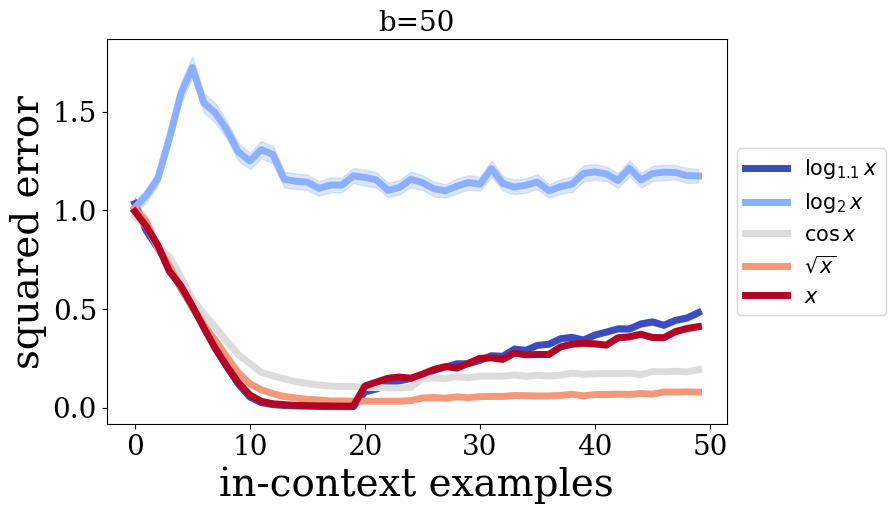

In [ ]:
ls, lw, fs = 28, 5, 15
ax = plot_results(res)
plt.rc('font', family='serif')
# ax.set_ylim(-0.1, 1.25)
ax.set_title("b=50", fontsize=20)
ax.set_xlabel("in-context examples", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

## Loop iterations

In [ ]:
def pointwise_error(preds, ys):
    # get mean across points for each loop
    return torch.nanmean((preds - ys).square(), dim=-1).T

In [ ]:
errs = {}
for k, v in runs.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides + ["model.n_loop_window=60", "model.n_loops=60", 'model.token_dec=0'])
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc, pointwise_error) 

<matplotlib.legend.Legend>

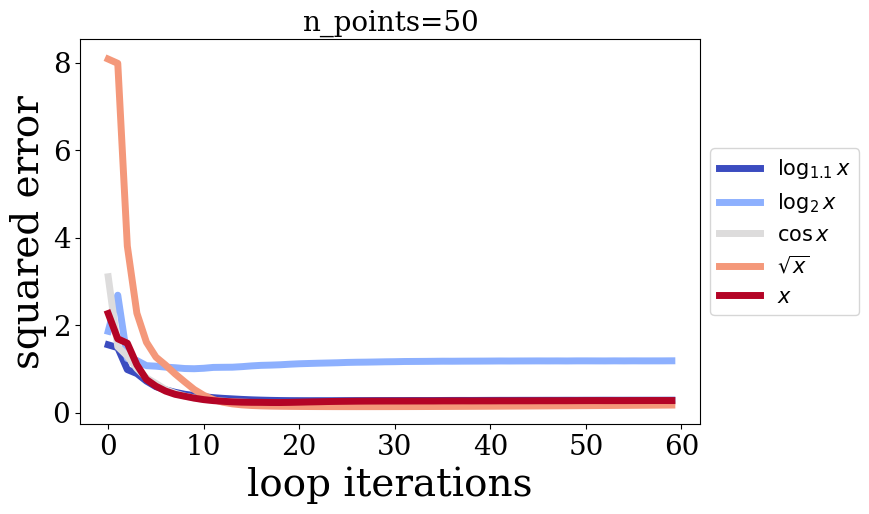

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)
ls, lw, fs = 28, 5, 15
ax = plot_results(res)
plt.rc('font', family='serif')
# ax.set_ylim(-0.1, 1.25)
ax.set_title(f"n_points=50", fontsize=20)
ax.set_xlabel("loop iterations", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)